# Run this Notebook

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DeepRLCourse/Homework-3-Questions/blob/main/HW3_P1_REINFORCE_VS_GA.ipynb)  
[![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/DeepRLCourse/Homework-3-Questions/blob/main/HW3_P1_REINFORCE_VS_GA.ipynb)

# HW3: REINFORCE Vs. GA
> - Full Name: **[Full Name]**
> - Student ID: **[Stundet ID]**


This notebook implements a Grid World environment where an agent learns to navigate from a start position to a goal while avoiding penalties. It compares two learning approaches:

1. REINFORCE Algorithm (Policy Gradient)
2. Genetic Algorithm

Follow the instructions in each section to complete the homework.

**Grading Breakdown:**

- Practical Implementation: 60 points
- Conceptual Understanding: 40 points

# Setup

All required packages are pre-installed if using Google Colab.

Import the following libraries.

In [24]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


# Environment (10 Points)

### GridWorld Class Definition (10 Points)

In [ ]:
# Grid World Parameters
GRID_SIZE = 7

# TODO: Specify the penalty locations on the Grid World. The number of penalty locations must be 8. {(x_1, y_1): penalty_reward, .... , (x_8, y_8): penalty_reward} 
PENALTIES = {
    (1, 1): -10, (2, 2): -10, (3, 3): -10, (4, 4): -10,
    (5, 1): -10, (1, 5): -10, (3, 1): -10, (5, 3): -10
} 

# TODO: Specify the goal location.        
GOAL = (6, 6) 

#  TODO: Properly assign values to the following rewards.               
GOAL_REWARD = 100
STEP_PENALTY = -1
BOUNDARY_PENALTY = -5

ACTIONS = ['up', 'down', 'left', 'right']
ACTION_IDX = {a: i for i, a in enumerate(ACTIONS)}

### GridWorld Environmnet Definition

In [11]:
class GridWorld:
    def step(self, state, action):
        x, y = state
        new_x, new_y = x, y

        if action == 'right':
            new_x = min(x + 1, GRID_SIZE - 1)
        elif action == 'left':
            new_x = max(x - 1, 0)
        elif action == 'up':
            new_y = min(y + 1, GRID_SIZE - 1)
        elif action == 'down':
            new_y = max(y - 1, 0)

        reward = STEP_PENALTY
        if (new_x, new_y) == (x, y):
            reward += BOUNDARY_PENALTY
        if (new_x, new_y) in PENALTIES:
            reward += PENALTIES[(new_x, new_y)]
        if (new_x, new_y) == GOAL:
            reward += GOAL_REWARD

        return (new_x, new_y), reward

### Initialize the Grid World

In [12]:
grid_world = GridWorld()

### Plot Empty Grid World

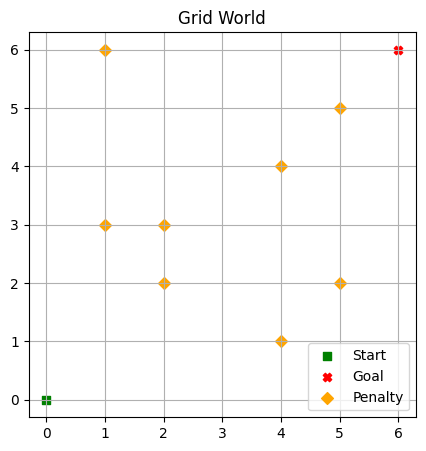

In [13]:
plt.figure(figsize=(5, 5))
plt.scatter(0, 0, c='green', marker='s', label='Start')
plt.scatter(GOAL[0], GOAL[1], c='red', marker='X', label='Goal')
for i, (px, py) in enumerate(PENALTIES):
    if i == 0:
        plt.scatter(px, py, c='orange', marker='D', label='Penalty')
    else:
        plt.scatter(px, py, c='orange', marker='D')
plt.xticks(range(GRID_SIZE))
plt.yticks(range(GRID_SIZE))
plt.title("Grid World")
plt.legend()
plt.grid(True)
plt.show()

# REINFORCE Algorithm (30 Points)

The REINFORCE algorithm updates policy parameters by using the log-probability of actions multiplied by the discounted return.

This algorithm optimizes a **stochastic policy** $( \pi_{\theta}(a_t \mid s_t) )$ by updating its parameters in the direction that increases expected rewards. The update rule is based on the **policy gradient theorem**:  

$$[
\theta \leftarrow \theta + \alpha \sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_t \mid s_t) G_t
]$$

where:  

- $( \theta )$ are the policy parameters (weights of the neural network).  
- $( \alpha )$ is the learning rate.  
- $( G_t )$ is the **discounted return** from timestep $( t )$:  

$$[
G_t = \sum_{k=0}^{T-t} \gamma^k R_{t+k}
]$$

- $( \nabla_{\theta} \log \pi_{\theta}(a_t \mid s_t) )$ is the gradient of the log-probability of the selected action, used to adjust the policy in the correct direction.

### Policy Network Definition (10 points)

In [ ]:
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim) # ToDo
        self.fc2 = nn.Linear(hidden_dim, output_dim) # ToDo
    
    def forward(self, state):
        x = torch.relu(self.fc1(state))  # ToDo
        return torch.log_softmax(self.fc2(x), dim=-1)  # ToDo


### REINFORCE Agent Implementation (20 Points)

In [ ]:
class ReinforceAgent:
    def __init__(self, lr=0.005, gamma=0.99):

        self.input_dim = 2    # ToDo - state is (x, y) coordinates
        self.output_dim = 4   # ToDo - 4 actions: up, down, left, right
        self.hidden_dim = 64  # ToDo - hidden layer size
        self.policy_net = PolicyNetwork(self.input_dim, self.output_dim, self.hidden_dim)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.gamma = gamma
    
    def train(self, episodes=6000, epsilon=1.0, epsilon_decay=0.9995, min_epsilon=0.01):
        for episode in range(episodes):
            state = (0, 0)
            trajectory, rewards = [], []
            
            while state != GOAL:
                state_tensor = torch.tensor(state, dtype=torch.float32)
                log_action_probs = self.policy_net(state_tensor).detach().numpy()
                action_probs = np.exp(log_action_probs)
                
                random_value = np.random.random()  # TODO: Generate a random number between 0 and 1.

                # Using an epsilon-greedy strategy to balance exploration & exploitation:
                if random_value < epsilon:
                    # TODO: Choose a random action (exploration) -> random choice from ACTIONS.
                    action = np.random.choice(ACTIONS)  # ToDo
                else:
                    # TODO: Choose the action with the highest probability (exploitation).
                    best_action_index = np.argmax(action_probs)  # Todo
                    action = ACTIONS[best_action_index]

                # TODO: Take a step in the Grid World based on the chosen action.
                new_state, reward = grid_world.step(state, action)

                # TODO: Store the current state, action taken, and received reward in the trajectory.
                trajectory.append((state, action, reward))

                # TODO: Record the reward to calculate returns later.
                rewards.append(reward)

                # TODO: Update the state to the new position for the next step.
                state = new_state
            
            returns, G = [], 0
            for r in reversed(rewards):
                G = r + self.gamma * G
                returns.insert(0, G)
            
            returns = torch.tensor(returns, dtype=torch.float32)
            baseline = returns.mean()
            returns -= baseline
            
            loss = 0
            for (state, action, _), G in zip(trajectory, returns):
                state_tensor = torch.tensor(state, dtype=torch.float32)
                log_action_probs = self.policy_net(state_tensor)
                loss -= log_action_probs[ACTION_IDX[action]] * G
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            epsilon = max(min_epsilon, epsilon * epsilon_decay)
            
            if episode % 50 == 0:
                print(f"Episode {episode}: Total Reward = {sum(rewards)}, Epsilon = {epsilon:.4f}")

    def get_optimal_trajectory(self):
        state = (0, 0)
        trajectory = [state]
        rewards = 0
        while state != GOAL:
            state_tensor = torch.tensor(state, dtype=torch.float32)
            log_action_probs = self.policy_net(state_tensor).detach().numpy()
            action_probs = np.exp(log_action_probs)
            action = np.random.choice(ACTIONS, p=action_probs / action_probs.sum())
            state, reward = grid_world.step(state, action)
            rewards += reward
            trajectory.append(state)
        return trajectory, rewards

# Genetic Algorithm


Genetic Algorithms (GAs) are optimization algorithms inspired by **natural selection**. They evolve a population of candidate solutions over multiple generations to find an optimal or near-optimal solution.

#### **1. Population ($P$)**
A **population** consists of multiple candidate solutions (individuals). Each individual represents a **policy or solution** encoded as a chromosome.

$$[
P_t = \{ X_1^t, X_2^t, ..., X_N^t \}
]$$

where:
- $( P_t )$ is the population at generation $( t )$,
- $( X_i^t )$ is the $( i )$-th individual in the population,
- $( N )$ is the population size.

#### **2. Fitness Function ($F$)**
Each individual is evaluated using a **fitness function**, which measures how good a solution is.

$$[
F(X_i) = \text{reward or performance score of } X_i
]$$

#### **3. Selection**
The best individuals are selected based on their fitness scores to produce the next generation. Common methods include:
- **Roulette Wheel Selection** (Probability proportional to fitness)
- **Tournament Selection** (Select the best out of a subset)

#### **4. Crossover (Recombination)**
Two parents **combine genetic information** to create offspring. A common method is **single-point crossover**, where a random crossover point is chosen.

$$
\begin{aligned}
\text{Parent 1} &= (A_1, A_2, | A_3, A_4, A_5) \\
\text{Parent 2} &= (B_1, B_2, | B_3, B_4, B_5) \\
\text{Offspring 1} &= (A_1, A_2, | B_3, B_4, B_5) \\
\text{Offspring 2} &= (B_1, B_2, | A_3, A_4, A_5)
\end{aligned}
$$

#### **5. Mutation**
Mutation introduces small **random changes** in individuals to maintain diversity and avoid local optima. If $( X_i )$ is an individual, a mutation function $( M )$ alters some genes:

$$[
X_i' = M(X_i)
]$$

For example, if an individual’s policy is `['up', 'right', 'down']`, mutation might randomly change `right` to `left`.

#### **6. Generations & Evolution**
The new population is formed after selection, crossover, and mutation. The process repeats for **multiple generations** until a stopping criterion is met (e.g., max generations or convergence).

$$[
P_{t+1} = \text{next\_generation}(P_t)
]$$



### Genetic Algorithm Implementation

In [16]:
class GeneticAlgorithm:
    def __init__(self, population_size, mutation_rate, crossover_rate, policy_network, generations=100, device='cpu'):
        self.device = device
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.generations = generations
        self.policy_network = policy_network.to(self.device)  # Move the model to GPU
        self.population = [self._initialize_individual() for _ in range(population_size)]

    def _initialize_individual(self):
        # Initialize an individual by setting random weights for the policy network
        individual = {}
        for name, param in self.policy_network.named_parameters():
            individual[name] = torch.randn_like(param).to(self.device)  # Move individual weights to GPU
        return individual

    def _evaluate_individual(self, individual):
        # Simulate the evaluation (for example, run a few episodes in GridWorld environment)
        self._apply_individual_weights(individual)
        state = (0, 0)
        STOP = 0
        trajectory, rewards = [], []
        while state != GOAL and STOP <= 150:
            state_tensor = torch.tensor(state, dtype=torch.float32).to(self.device)  # Move state to GPU
            log_action_probs = self.policy_network(state_tensor)
            action_probs = torch.exp(log_action_probs)
            action_idx = torch.argmax(action_probs).item()  # Get action with highest probability
            action = ACTIONS[action_idx]  # Map action index back to action
            new_state, reward = grid_world.step(state, action)
            trajectory.append((state, action, reward))
            rewards.append(reward)
            state = new_state
            STOP += 1
        return sum(rewards)

    def _apply_individual_weights(self, individual):
        # Apply the weights of an individual to the policy network
        for name, param in individual.items():
            self.policy_network.state_dict()[name].copy_(param)

    def _select_parents(self):
        # Select two individuals based on fitness (higher reward is better)
        scores = [(ind, self._evaluate_individual(ind)) for ind in self.population]
        sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
        parent1 = sorted_scores[0][0]
        parent2 = sorted_scores[1][0]
        return parent1, parent2

    def _crossover(self, parent1, parent2):
        # Perform crossover to combine the genetic material of two parents
        child = {}
        for name in parent1.keys():
            if random.random() < self.crossover_rate:
                child[name] = parent1[name]
            else:
                child[name] = parent2[name]
        return child

    def _mutate(self, individual):
        # Perform mutation (randomly modify the weights)
        for name, param in individual.items():
            if random.random() < self.mutation_rate:
                individual[name] = torch.randn_like(param).to(self.device)  # Ensure mutated weight is on GPU
        return individual

    def run(self):
        for generation in range(self.generations):
            new_population = []
            for _ in range(self.population_size // 2):
                parent1, parent2 = self._select_parents()
                child1 = self._crossover(parent1, parent2)
                child2 = self._crossover(parent2, parent1)
                new_population.append(self._mutate(child1))
                new_population.append(self._mutate(child2))
            self.population = new_population
            print(f"Generation {generation + 1} completed")

    def get_optimal_trajectory(self):
        state = (0, 0)
        trajectory = [state]
        rewards = 0
        STOP = 0
        while state != GOAL and STOP <= 150:
            state_tensor = torch.tensor(state, dtype=torch.float32).to(self.device)  # Move state to GPU
            log_action_probs = self.policy_network(state_tensor)
            action_probs = torch.exp(log_action_probs)
            action_idx = torch.argmax(action_probs).item()  # Get action with highest probability
            action = ACTIONS[action_idx]  # Map action index back to action
            state, reward = grid_world.step(state, action)
            rewards += reward
            trajectory.append(state)
            STOP += 1
        return trajectory, rewards

# Running & Comparing Agents (20 Points)

In [ ]:
# Train REINFORCE agent

LEARNING_RATE = 0.005  # ToDo
GAMMA = 0.99          # ToDo

reinforce_agent = ReinforceAgent(lr = LEARNING_RATE, gamma = GAMMA)
reinforce_agent.train(episodes=6000, epsilon=1.0, epsilon_decay=0.9995, min_epsilon=0.1)

Episode 0: Total Reward = -386, Epsilon = 0.9995
Episode 50: Total Reward = -296, Epsilon = 0.9748
Episode 100: Total Reward = -10, Epsilon = 0.9507
Episode 150: Total Reward = -281, Epsilon = 0.9273
Episode 200: Total Reward = -48, Epsilon = 0.9044
Episode 250: Total Reward = -80, Epsilon = 0.8820
Episode 300: Total Reward = -22, Epsilon = 0.8602
Episode 350: Total Reward = -366, Epsilon = 0.8390
Episode 400: Total Reward = -8, Epsilon = 0.8183
Episode 450: Total Reward = -240, Epsilon = 0.7981
Episode 500: Total Reward = -376, Epsilon = 0.7784
Episode 550: Total Reward = 40, Epsilon = 0.7591
Episode 600: Total Reward = -232, Epsilon = 0.7404
Episode 650: Total Reward = -28, Epsilon = 0.7221
Episode 700: Total Reward = 0, Epsilon = 0.7043
Episode 750: Total Reward = -74, Epsilon = 0.6869
Episode 800: Total Reward = -386, Epsilon = 0.6699
Episode 850: Total Reward = -356, Epsilon = 0.6534
Episode 900: Total Reward = 42, Epsilon = 0.6372
Episode 950: Total Reward = -396, Epsilon = 0.621

In [ ]:
# Train Genetic Algorithm agent

POPULATION_SIZE = 50  # ToDo
GENERATIONS = 100     # ToDo
MUTATION_RATE = 0.1   # ToDo
CROSSOVER_RATE = 0.8  # ToDo

policy_network = PolicyNetwork(input_dim=2, output_dim=4, hidden_dim=64)
genetic_agent = GeneticAlgorithm(generations=GENERATIONS, population_size=POPULATION_SIZE, mutation_rate=MUTATION_RATE, crossover_rate=CROSSOVER_RATE, policy_network=policy_network, device=device)
optimal_genetic_policy = genetic_agent.run()

Generation 1 completed
Generation 2 completed
Generation 3 completed
Generation 4 completed
Generation 5 completed
Generation 6 completed
Generation 7 completed
Generation 8 completed
Generation 9 completed
Generation 10 completed
Generation 11 completed
Generation 12 completed
Generation 13 completed
Generation 14 completed
Generation 15 completed
Generation 16 completed
Generation 17 completed
Generation 18 completed
Generation 19 completed
Generation 20 completed
Generation 21 completed
Generation 22 completed
Generation 23 completed
Generation 24 completed
Generation 25 completed
Generation 26 completed
Generation 27 completed
Generation 28 completed
Generation 29 completed
Generation 30 completed
Generation 31 completed
Generation 32 completed
Generation 33 completed
Generation 34 completed
Generation 35 completed
Generation 36 completed
Generation 37 completed
Generation 38 completed
Generation 39 completed
Generation 40 completed
Generation 41 completed
Generation 42 completed
G

# Visualizing Results (40 Points)

Plots the agent’s trajectory in the Grid World.

In [26]:
def visualize_trajectory(trajectory, title):
    plt.figure(figsize=(5, 5))
    x_vals, y_vals = zip(*trajectory)
    plt.plot(x_vals, y_vals, marker='o', color='blue', linestyle='-', alpha=0.7)
    plt.scatter(0, 0, c='green', marker='s', label='Start')
    plt.scatter(GOAL[0], GOAL[1], c='red', marker='X', label='Goal')
    for i, (px, py) in enumerate(PENALTIES):
        if i == 0:
            plt.scatter(px, py, c='orange', marker='D', label='Penalty')
        else:
            plt.scatter(px, py, c='orange', marker='D')
    plt.xticks(range(GRID_SIZE))
    plt.yticks(range(GRID_SIZE))
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

### Results

Final Reward (REINFORCE): 88



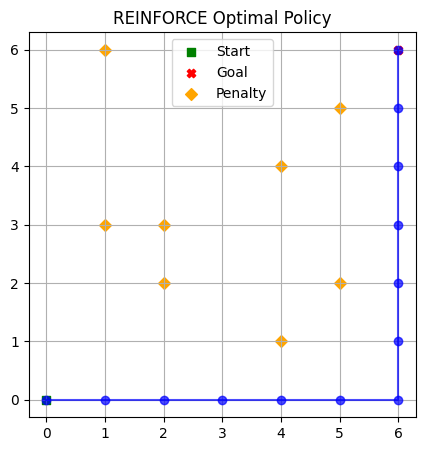


--------------------------------------------------------------------------------------

Final Reward (Genetic Algorithm): 88



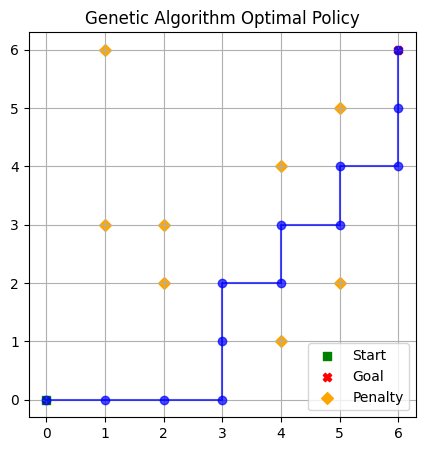

In [36]:
# Results

optimal_reinforce_trajectory, final_reward_reinforce = reinforce_agent.get_optimal_trajectory()
print(f"Final Reward (REINFORCE): {final_reward_reinforce}\n")
visualize_trajectory(optimal_reinforce_trajectory, "REINFORCE Optimal Policy")

print("\n--------------------------------------------------------------------------------------\n")

optimal_genetic_trajectory, final_reward_genetic = genetic_agent.get_optimal_trajectory()
print(f"Final Reward (Genetic Algorithm): {final_reward_genetic}\n")
visualize_trajectory(optimal_genetic_trajectory, "Genetic Algorithm Optimal Policy")

$\bullet$ Based on the implementation and results from comparing policy search using Genetic Algorithm (GA) and the REINFORCE algorithm: 

**Question 1:** (10 points)

How do these two methods differ in terms of their effectiveness for solving reinforcement learning tasks? 

**Answer:** The two methods differ significantly in their approach and effectiveness:

- **REINFORCE** is a policy gradient method that directly optimizes the policy parameters using gradient descent. It learns by estimating the gradient of the expected return with respect to policy parameters and updates them in the direction that increases expected rewards. This makes it more sample-efficient for continuous optimization problems and can handle stochastic policies naturally.

- **Genetic Algorithm** is a population-based evolutionary approach that maintains a population of candidate solutions (policies) and evolves them through selection, crossover, and mutation operations. It doesn't require gradient information and can escape local optima more effectively, but typically requires more evaluations and may be less sample-efficient for smooth optimization landscapes.

**Question 2:** (15 points)

Discuss the key differences in their **performance**, **convergence rates**, and **stability**. 

**Answer:** 

**Performance:**
- REINFORCE typically achieves better final performance due to its direct gradient-based optimization, which allows for precise parameter updates
- GA may struggle with fine-tuning but can find diverse solutions and avoid getting stuck in poor local optima

**Convergence Rates:**
- REINFORCE generally converges faster as it uses gradient information to make informed updates toward better policies
- GA converges more slowly as it relies on random mutations and crossover operations, requiring many generations to refine solutions

**Stability:**
- REINFORCE can be unstable due to high variance in gradient estimates, especially with sparse rewards
- GA is more stable as it maintains population diversity and doesn't rely on potentially noisy gradient estimates

**Question 3:** (15 points)

Additionally, explore how each method handles exploration and exploitation, and suggest situations where one might be preferred over the other. 

**Answer:**

**Exploration vs Exploitation:**

**REINFORCE:**
- Uses epsilon-greedy strategy for exploration during training
- Exploits gradient information to make informed updates
- Exploration decreases over time as epsilon decays
- Can get stuck in local optima if exploration is insufficient

**Genetic Algorithm:**
- Maintains population diversity for exploration
- Uses mutation to introduce random changes (exploration)
- Selection pressure drives exploitation of better solutions
- Crossover combines good traits from different individuals

**When to prefer each method:**

**Prefer REINFORCE when:**
- The problem has smooth reward landscapes
- Sample efficiency is important
- You have access to gradient information
- The policy space is continuous and differentiable

**Prefer Genetic Algorithm when:**
- The reward landscape has many local optima
- The problem is discrete or non-differentiable
- You need diverse solutions
- Gradient information is not available or unreliable
- The problem has complex, multi-modal fitness landscapes